### 1. Import Libraries

In [1]:
from torchvision.models import resnet50, ResNet50_Weights
from src.model import Model
import json
import scipy.ndimage as ndi
import numpy as np
import random
import PIL
import torch
from src.utils import prepare_input, get_segments
from src.base_explainer import explainer
from src.explainers import (
    intgrad_explainer,
    smoothgrad_explainer,
    saliency_explainer,
    vargrad_explainer
)
from src.agg_explainers import AGGopt_explainer
from src.plot import plot_agg_explanations


SEED = 0
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed_all(SEED)

### 2. Load Model

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

resnet_model.eval() 
transforms = ResNet50_Weights.IMAGENET1K_V1.transforms()
model = Model(resnet_model, device=device)


### 3. Load Data

In [3]:
org_image, input_data = prepare_input('images/catdog.png', transforms=transforms)
blurred_img = ndi.gaussian_filter(org_image, sigma=(10,10,0))
segments = get_segments(input_data, algo='slic', n_segments=50)
baseline = transforms(PIL.Image.fromarray(blurred_img, 'RGB')).to(device)

input_data = input_data.to(device)
input_data.requires_grad = True

with open('data/imagenet_class_index.json', 'r') as f:
    class_idx_mapping = json.load(f)
    
pred_class_idx = torch.argmax(model(input_data)).item()
pred_class_name = class_idx_mapping[str(pred_class_idx)][1]

### 4. Load Explainer Classes

In [4]:
intgrad = intgrad_explainer(model)
smoothgrad = smoothgrad_explainer(model)
saliency = saliency_explainer(model)
vargrad = vargrad_explainer(model)

saliency_kwargs = {'abs': False}
intgrad_kwargs = {'baselines': torch.zeros_like(input_data)}
smoothgrad_kwargs = {}
vargrad_kwargs = {}

explainers = [saliency ,intgrad, smoothgrad, vargrad]
explainers_kwargs = [saliency_kwargs, intgrad_kwargs, smoothgrad_kwargs, vargrad_kwargs]

In [5]:
agg_opt = AGGopt_explainer(model, explainers, explainers_kwargs,baseline=baseline, segments=segments)

### 5. Call explain() function

In [ ]:
explanation_agg_opt = agg_opt.explain(input_data, pred_class_idx)

### 6. Plot explanations

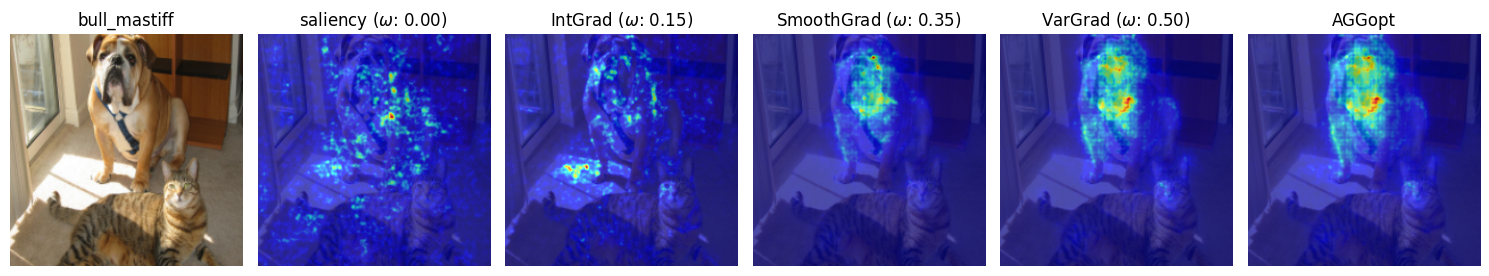

In [7]:
plot_agg_explanations(input_data.detach(), agg_opt.explanations, label=pred_class_name, overlay=True, weights=agg_opt.get_weights(), figsize=(15, 10))